# Regression Analysis
## Model
$$ Supply: P = aQ + sigma $$
$$ Demand: P = aQ + b*Income + c*subscriptionRate + Race + Age + Borough(InstrumentalVariable) + sigma $$
$$ P = aQ + bIncome + c*subscriptionRate + Race + Age + Borough + sigma $$

The regression is done in both demand and supply side. Our datasets include the latest FCC fixed broadband dataset in 2019, ACS demographic datasets for income, age and race, in 2010 and ACS subscription dataset in 2018. For comparison, we also did the regression using FCC and ACS datasets in 2017.

## Data preparation
### Independent variables: Income, Race, Age, Borough

In [1]:
import pandas as pd
import numpy as np

In [2]:
# import Income data in percentage
income = pd.read_csv('data/Demographics/Income/household_income_acs2018.csv')
income = income.sort_values(by='tract')
income = income.drop(columns=['city','tract','Households (HH) Count','Household Median Income','Household Mean Income'])
income.columns = income.columns.str.replace('HH ', '')
income['BoroCTLbl'] = income['BoroCTLbl'].astype(str)
income.head()

,county,BoroCTLbl,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,k75_k100,k100_k150,k150_k200,k200_UP
0,Bronx,Bronx 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1100,Manhattan,Manhattan 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1388,Queens,Queens 1,4.9,0.3,2.5,2.2,2.6,8.2,10.5,20.9,15.8,32.2
339,Brooklyn,Brooklyn 1,3.2,2.2,9.4,2.7,5.0,14.0,19.3,9.8,13.9,20.5
340,Brooklyn,Brooklyn 2,11.6,5.3,6.1,23.8,10.8,21.1,6.4,8.6,1.1,5.3


In [3]:
# Race data in percentage
race = pd.read_csv('data/Demographics/Basic Count/tract_race_acs2018.csv')
race = race.assign(White = lambda x: x["White"]/x["Total"]*100,
                  Black = lambda x: x["Black"]/x["Total"]*100,
                  Native = lambda x: x["Native"]/x["Total"]*100,
                  Asian = lambda x: x["Asian"]/x["Total"]*100,
                  PacificIslander = lambda x: x["Pacific_Islander"]/x["Total"]*100,
                  Other = lambda x: x["Other"]/x["Total"]*100,
                  TwoOrMore = lambda x: x["Two or More"]/x["Total"]*100)
race = race.fillna(0)
race = race.drop(columns=['city','county','Total','Two or More','Pacific_Islander']).sort_values(by='tract')
race['BoroCTLbl'] = race['BoroCTLbl'].astype(str)
race.head()

,tract,BoroCTLbl,White,Black,Native,Asian,Other,PacificIslander,TwoOrMore
23,1.0,Bronx 1,25.042373,59.872881,0.353107,1.765537,12.005650,0.0,0.960452
907,1.0,Brooklyn 1,65.280572,15.157612,0.715404,8.920188,5.902079,0.0,4.024145
1225,1.0,Manhattan 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1742,1.0,Queens 1,64.054360,5.594564,0.000000,22.808607,2.061155,0.0,5.481314
590,2.0,Brooklyn 2,45.132743,3.861625,0.000000,4.987932,41.029767,0.0,4.987932


In [4]:
# Age data
age = pd.read_csv('data/Demographics/Age_Sex/tract_age_sex_acs2018.csv')
age = age.sort_values(by='tract')
age = age.drop(columns=['Male','Female'])
for i in range(5,len(age.columns)):
    age.iloc[:,i] = age.iloc[:,i]/age.loc[:,'Total']*100
age = age.fillna(0)
age = age.drop(columns=['tract','county','city','Total'])
age['BoroCTLbl'] = age['BoroCTLbl'].astype(str)
age.head()

,BoroCTLbl,A00_A05,A05_A09,A10_A14,A15_A19,A20_A24,A25_A29,A30_A34,A35_A39,A40_A44,A45_A49,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP
0,Bronx 1,0.000000,0.000000,0.000000,7.641243,15.805085,14.449153,14.731638,13.516949,9.957627,8.375706,8.629944,4.788136,1.384181,0.720339,0.000000,0.000000,0.000000,0.000000
1100,Manhattan 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1388,Queens 1,10.192525,4.903737,1.155153,0.826727,2.740657,14.530011,20.928652,13.091733,9.331823,8.505096,4.043035,3.816535,2.627407,0.486976,1.778029,1.041903,0.000000,0.000000
339,Brooklyn 1,4.560698,4.381847,2.638051,3.822938,1.922647,7.467024,7.780013,8.562486,8.338922,11.133467,6.751621,5.097250,7.802370,9.300246,3.241672,3.264029,0.804829,3.129890
340,Brooklyn 2,3.459372,8.286404,8.688656,5.390185,8.769107,12.228479,11.263073,5.390185,6.436042,9.654063,6.275141,4.666130,0.884956,3.459372,1.126307,1.287208,1.528560,1.206758


In [5]:
# Borough data
borough = income.iloc[:,:2]
borough_name = ['Bronx','Brooklyn','Queens','Manhattan','Staten Island']
for i in borough_name:
    borough[i] = 0
for i in range(len(borough)):
    boro = borough.loc[i,'county']
    borough.loc[i,boro] = 1
borough = borough.drop(columns=['county'])
borough['BoroCTLbl'] = borough['BoroCTLbl'].astype(str)
borough.columns = borough.columns.str.replace('Staten Island', 'Staten_Island')
borough.head() 

,BoroCTLbl,Bronx,Brooklyn,Queens,Manhattan,Staten_Island
0,Bronx 1,1,0,0,0,0
1100,Manhattan 1,0,0,0,1,0
1388,Queens 1,0,0,1,0,0
339,Brooklyn 1,0,1,0,0,0
340,Brooklyn 2,0,1,0,0,0


### Broadband data

In [6]:
import geopandas as gpd
census_tracts = gpd.read_file("data/2010_Census_Tracts/geo_export_0ca1f0a1-f242-497a-9f86-91b88fc18647.shp")

In [7]:
# number of internet providers Q
# 2-digit code indicating the Technology of Transmission used to offer broadband service. 
def tech_code_translator(x):
    # ADSL, Cable, Fiber, Fixed Wireless, Satellite, Other
    if x in ['10', '11', '12', '20', '30']:
        return 'ADSL'
    if x in ['40', '41', '42', '43']:
        return 'Cable'
    if x == '50':
        return 'Fiber'
    if x == '60':
        return 'Satellite'
    if x == '70':
        return 'Fixed Wireless'
    return 'Other'
converters = {'tract': lambda x: str(x), 
              'block': lambda x: str(x),
              'Technology Code': lambda x: tech_code_translator(x)
             }
fcc477_broadband = pd.read_csv('data/Fixed_Broadband_Deployment_Data__Jun__2019_Status_V1.csv',converters = converters, encoding = "ISO-8859-1")
fcc477_broadband.rename(columns={'Census Block FIPS Code':'FIPS Code'}, inplace=True)
# get FIPS 11: state + county + tract
fcc477_broadband["FIPS Code"] = fcc477_broadband["FIPS Code"].astype(str)
fcc477_broadband["FIPS_11"] = fcc477_broadband["FIPS Code"].str[:11]
# filter for unique providers in each tract that provide broadband service
fcc477_broadband = fcc477_broadband[(fcc477_broadband["Max Advertised Downstream Speed (mbps)"]>=25.0)&(fcc477_broadband["Max Advertised Upstream Speed (mbps)"]>=3.0)]

In [8]:
broadband_ISP = fcc477_broadband.groupby(["FIPS_11", "boro"]).agg(
    providers = pd.NamedAgg(column = "Provider Name", aggfunc = lambda x: set(x)))

broadband_ISP.reset_index(inplace=True)
broadband_ISP["ct2010"] = broadband_ISP["FIPS_11"].str[5:]
broadband_ISP["boro"] = broadband_ISP["boro"].replace({"bronx": "Bronx",
                                                                    "brooklyn": "Brooklyn",
                                                                    "manhattan": "Manhattan",
                                                                    "staten island": "Staten Island",
                                                                    "queens": "Queens"})
for i in range(len(broadband_ISP)):
    broadband_ISP.loc[i,'providers'] = list(broadband_ISP.loc[i,'providers'])
# merge
broadband_ISP_merged = broadband_ISP.merge(census_tracts.loc[:,["boro_name", "ct2010", "ctlabel"]], right_on = ["ct2010", "boro_name"], left_on = ["ct2010", "boro"])
# new common column
broadband_ISP_merged["BoroCTLbl"] = broadband_ISP_merged["boro_name"] + " " + broadband_ISP_merged["ctlabel"].astype(str)
for i in range(len(broadband_ISP_merged)):
    broadband_ISP_merged.loc[i,'num_providers'] = len(broadband_ISP_merged.loc[i,'providers'])

broadband_ISP_merged = broadband_ISP_merged.drop(columns=['FIPS_11','ct2010','boro_name'])
broadband_ISP_merged.head()

,boro,providers,ctlabel,BoroCTLbl,num_providers
0,Bronx,"[ViaSat, Inc., RCN Telecom Services of New Yor...",1,Bronx 1,3.0
1,Bronx,"[ViaSat, Inc., CSC Holdings LLC, HNS License S...",2,Bronx 2,4.0
2,Bronx,"[ViaSat, Inc., CSC Holdings LLC, HNS License S...",4,Bronx 4,4.0
3,Bronx,"[ViaSat, Inc., CSC Holdings LLC, HNS License S...",16,Bronx 16,4.0
4,Bronx,"[ViaSat, Inc., CSC Holdings LLC, HNS License S...",19,Bronx 19,4.0


In [16]:
# get 2017 data
fcc477_broadband = pd.read_csv('data/Fixed_Broadband_Deployment_Data__Jun__2017_Status_V1.csv',converters = converters, encoding = "ISO-8859-1")
fcc477_broadband.rename(columns={'Census Block FIPS Code':'FIPS Code'}, inplace=True)
# get FIPS 11: state + county + tract
fcc477_broadband["FIPS Code"] = fcc477_broadband["FIPS Code"].astype(str)
fcc477_broadband["FIPS_11"] = fcc477_broadband["FIPS Code"].str[:11]
# filter for unique providers in each tract that provide broadband service
fcc477_broadband = fcc477_broadband[(fcc477_broadband["Max Advertised Downstream Speed (mbps)"]>=25.0)&(fcc477_broadband["Max Advertised Upstream Speed (mbps)"]>=3.0)]
broadband_ISP = fcc477_broadband.groupby(["FIPS_11", "boro"]).agg(
    providers = pd.NamedAgg(column = "Provider Name", aggfunc = lambda x: set(x)))
broadband_ISP.reset_index(inplace=True)
broadband_ISP["ct2010"] = broadband_ISP["FIPS_11"].str[5:]
broadband_ISP["boro"] = broadband_ISP["boro"].replace({"bronx": "Bronx",
                                                                    "brooklyn": "Brooklyn",
                                                                    "manhattan": "Manhattan",
                                                                    "staten island": "Staten Island",
                                                                    "queens": "Queens"})
for i in range(len(broadband_ISP)):
    broadband_ISP.loc[i,'providers'] = list(broadband_ISP.loc[i,'providers'])
# merge
broadband_ISP_merged_2017 = broadband_ISP.merge(census_tracts.loc[:,["boro_name", "ct2010", "ctlabel"]], right_on = ["ct2010", "boro_name"], left_on = ["ct2010", "boro"])
# new common column
broadband_ISP_merged_2017["BoroCTLbl"] = broadband_ISP_merged_2017["boro_name"] + " " + broadband_ISP_merged_2017["ctlabel"].astype(str)
for i in range(len(broadband_ISP_merged_2017)):
    broadband_ISP_merged_2017.loc[i,'num_providers'] = len(broadband_ISP_merged_2017.loc[i,'providers'])
broadband_ISP_merged_2017 = broadband_ISP_merged_2017.drop(columns=['FIPS_11','ct2010','boro_name'])
broadband_ISP_merged_2017.head()

,boro,providers,ctlabel,BoroCTLbl,num_providers
0,Bronx,"[ViaSat, Inc., RCN Telecom Services of New Yor...",1,Bronx 1,3.0
1,Bronx,"[ViaSat, Inc., CSC Holdings LLC, HNS License S...",2,Bronx 2,4.0
2,Bronx,"[ViaSat, Inc., CSC Holdings LLC, HNS License S...",4,Bronx 4,4.0
3,Bronx,"[ViaSat, Inc., CSC Holdings LLC, HNS License S...",16,Bronx 16,4.0
4,Bronx,"[ViaSat, Inc., CSC Holdings LLC, HNS License S...",19,Bronx 19,4.0


Calculate prices in each census tract. Idealy, for both broadband and mobile, we need to know how many people register for one certain plan of one company, and then calculate the weighted average price in this tract. 

In [25]:
all_provider = []
for i in range(len(broadband_ISP_merged)):
    for value in broadband_ISP_merged.loc[i,'providers']:
        all_provider.append(value)
set(all_provider)

{'Atlantech Online, Inc.',
 'Berkshire Telephone Corp.',
 'Brooklyn Fiber',
 'CSC Holdings LLC',
 'Charter Communications, Inc.',
 'Chautauqua & Erie Telephone Corporation',
 'HNS License Sub, LLC',
 'Honest Networks, Inc.',
 'Nuvisions',
 'RCN Telecom Services of New York, LP',
 'Sky Fiber Internet',
 'Starry, Inc',
 'TELECOM PROFESSIONALS',
 'Taconic Telephone Corp.',
 'Verizon New York Inc.',
 'ViaSat, Inc.',
 'XCHANGE TELECOM CORP.'}

In [24]:
# 2017 version
all_provider_2017 = []
for i in range(len(broadband_ISP_merged_2017)):
    for value in broadband_ISP_merged_2017.loc[i,'providers']:
        all_provider_2017.append(value)
set(all_provider_2017)

{'Aeronet Wireless Broadband LLC',
 'Atlantic Broadband Finance, LLC',
 'Berkshire Telephone Corp.',
 'COMCAST CABLE COMMUNICATIONS, LLC',
 'CSC Holdings LLC',
 'California Internet, L.P. DBA GeoLinks',
 'Charter Communications, Inc.',
 'HNS License Sub, LLC',
 'Hotwire Communications, Ltd.',
 'RCN Telecom Services of New York, LP',
 'Taconic Telephone Corp.',
 'Verizon New York Inc.',
 'ViaSat, Inc.',
 'XCHANGE TELECOM CORP.'}

In [18]:
broadband_price = pd.read_excel('data/Broadband Prices/Broadband Provider-Compare_v.2.xlsx')
price = broadband_price[['1 Line $/month','2 Lines $/month','3 Lines $/month','4 Lines $/month']]
broadband_price['avg_price'] = price.mean(axis=1)
broadband_price = broadband_price.groupby(['ISP']).agg(average_price = pd.NamedAgg(column = 'avg_price', aggfunc = lambda x: np.mean(x)))
broadband_price = broadband_price.reset_index()
# price info: https://www.inmyarea.com/internet/new-york/new-york
broadband_price = broadband_price.append(pd.DataFrame(
    [['Brooklyn Fiber',100],
     ['HughesNet',69.99],
     ['Honest',50],
     ['RCN',39.99],
     ['SkyFiber',99],
     ['Starry',50],
     ['Consolidated',73.85],
     ['ViaSat',50],
    ['AeroNet',94],
    ['Xfinity',73.32],
    ['GeoLinks',104],
    ['Hotwire',229.99]],
    columns=['ISP','average_price']))

In [19]:
ISP_price = {key:values for key , values in zip(broadband_price['ISP'],broadband_price['average_price'])}
ISP_price

{'AT&T Mobility': 89.86111111111111,
 'Altice USA': 62.5,
 'Average': 100.4225863564099,
 'Boost Mobile': 115.3125,
 'Charter': 86.0,
 'Google Fi': 86.25,
 'Max': 186.25,
 'Median': 100.0,
 'Metro': 82.5,
 'Min': 35.0,
 'Sprint': 96.25,
 'Std. Dev. (σ)': 53.904429974993775,
 'T-Mobile': 92.5,
 'Ting': 59.666666666666664,
 'Tracfone': 41.111111111111114,
 'U.S. Cellular': nan,
 'Verizon Wireless': 92.5,
 'Virgin Mobile': 46.666666666666664,
 'Brooklyn Fiber': 100.0,
 'HughesNet': 69.99,
 'Honest': 50.0,
 'RCN': 39.99,
 'SkyFiber': 99.0,
 'Starry': 50.0,
 'Consolidated': 73.85,
 'ViaSat': 50.0,
 'AeroNet': 94.0,
 'Xfinity': 73.32,
 'GeoLinks': 104.0,
 'Hotwire': 229.99}

In [20]:
# match them
ISP_company = {'Atlantech Online, Inc.': 'AOI',
               'Atlantic Broadband Finance, LLC': 'AOI',
               'Aeronet Wireless Broadband LLC': 'AeroNet',
              'Berkshire Telephone Corp.': 'Berkshire',
              'Brooklyn Fiber': 'Brooklyn Fiber',
              'California Internet, L.P. DBA GeoLinks': 'GeoLinks',
              'CSC Holdings LLC': 'Altice USA',
              'COMCAST CABLE COMMUNICATIONS, LLC': 'Xfinity',
              'Charter Communications, Inc.': 'Charter',
              'Chautauqua & Erie Telephone Corporation': 'C&E Corp',
              'HNS License Sub, LLC': 'HughesNet',
               'Hotwire Communications, Ltd.': 'Hotwire',
              'Honest Networks, Inc.': 'Honest',
              'Nuvisions': 'Nuvisions',
              'RCN Telecom Services of New York, LP': 'RCN',
              'Sky Fiber Internet': 'SkyFiber',
              'Starry, Inc': 'Starry',
              'TELECOM PROFESSIONALS': 'TELECOM PROFESSIONALS',
              'Taconic Telephone Corp.': 'Consolidated',
              'Verizon New York Inc.': 'Verizon Wireless',
              'ViaSat, Inc.': 'ViaSat',
              'XCHANGE TELECOM CORP.': 'XChange'}

In [26]:
# match prices
broadband_ISP_merged_price = []
for i in range(len(broadband_ISP_merged)):
    tract_price = []
    for isp in broadband_ISP_merged.loc[i,'providers']:
        if isp in ISP_company.keys() and ISP_company[isp] in ISP_price.keys():
            tract_price.append(ISP_price[ISP_company[isp]])
    broadband_ISP_merged_price.append(np.mean(tract_price))
broadband_ISP_merged['price'] = np.array(broadband_ISP_merged_price)
#broadband_ISP_merged.to_csv('broadband_price_census2018.csv',index=False)

In [27]:
broadband_ISP_merged_concise = broadband_ISP_merged.drop(columns=['boro','providers','ctlabel'])
broadband_ISP_merged_concise['BoroCTLbl'] = broadband_ISP_merged_concise['BoroCTLbl'].astype(str)
broadband_ISP_merged_concise.head()

,BoroCTLbl,num_providers,price
0,Bronx 1,3.0,53.326667
1,Bronx 2,4.0,68.747500
2,Bronx 4,4.0,68.747500
3,Bronx 16,4.0,68.747500
4,Bronx 19,4.0,68.747500


In [30]:
# 2017 version
broadband_ISP_merged_price_2017 = []
for i in range(len(broadband_ISP_merged_2017)):
    tract_price = []
    for isp in broadband_ISP_merged.loc[i,'providers']:
        if isp in ISP_company.keys() and ISP_company[isp] in ISP_price.keys():
            tract_price.append(ISP_price[ISP_company[isp]])
    broadband_ISP_merged_price_2017.append(np.mean(tract_price))
broadband_ISP_merged_2017['price'] = np.array(broadband_ISP_merged_price_2017)
    
broadband_ISP_merged_concise_2017 = broadband_ISP_merged_2017.drop(columns=['boro','providers','ctlabel'])
broadband_ISP_merged_concise_2017['BoroCTLbl'] = broadband_ISP_merged_concise_2017['BoroCTLbl'].astype(str)
broadband_ISP_merged_concise_2017.head()

,BoroCTLbl,num_providers,price
0,Bronx 1,3.0,53.326667
1,Bronx 2,4.0,68.747500
2,Bronx 4,4.0,68.747500
3,Bronx 16,4.0,68.747500
4,Bronx 19,4.0,68.747500


Subscription data

In [15]:
# load subscription dataset in 2018 and transfrom values to percentage
subscription = pd.read_csv("data/ACS_Internet_Subscription/subscription_acs_2018.csv")
subscription = subscription.assign(Mobile_Dependent = lambda x: x["Mobile_Dependent"]/x["Total"]*100,
                                   Wired_Broadband = lambda x: x["Wired_Broadband"]/x["Total"]*100,
                                   No_Internet = lambda x: x["No_Internet"]/x["Total"]*100)
subscription = subscription.drop(columns=['city','tract','county','Total'])
subscription.head()

,BoroCTLbl,Mobile_Dependent,Wired_Broadband,No_Internet
0,Bronx 429.02,9.005629,62.664165,26.203877
1,Bronx 330,4.227337,69.375294,19.116956
2,Bronx 358,8.186656,71.428571,10.028653
3,Bronx 371,5.405405,53.306498,36.112708
4,Bronx 385,9.378734,52.568698,28.076464


In [32]:
# we also have the subscription data in 2017
subscription_2017 = pd.read_csv("data/ACS_Internet_Subscription/subscription_acs_2017.csv")
subscription_2017 = subscription_2017.assign(Mobile_Dependent = lambda x: x["Mobile_Dependent"]/x["Total"]*100,
                                   Wired_Broadband = lambda x: x["Wired_Broadband"]/x["Total"]*100,
                                   No_Internet = lambda x: x["No_Internet"]/x["Total"]*100)
subscription_2017 = subscription_2017.drop(columns=['city','tract','county','Total']).fillna(0)
subscription_2017.head()

,BoroCTLbl,Mobile_Dependent,Wired_Broadband,No_Internet
0,Bronx 1,0.000000,0.000000,0.000000
1,Bronx 2,5.526117,71.536715,17.032551
2,Bronx 4,3.927649,74.211886,16.124031
3,Bronx 16,5.300714,62.589195,24.821611
4,Bronx 19,5.263158,76.160991,13.622291


## Regression

In [65]:
# merge data and get log value
pqi = broadband_ISP_merged_concise.merge(income, on='BoroCTLbl')
pqir = pqi.merge(race, on='BoroCTLbl')
pqirb = pqir.merge(borough, on='BoroCTLbl')
pqirba = pqirb.merge(subscription, on='BoroCTLbl')
pqirbas = pqirba.merge(age, on='BoroCTLbl')
pqirbas = pqirbas.drop(columns=['BoroCTLbl','county','tract']).fillna(0)
for i in pqirbas.columns:
    pqirbas[i] = pqirbas[i].apply(np.log1p)
pqirbas.head()

,num_providers,price,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,k75_k100,k100_k150,...,A40_A44,A45_A49,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP
0,1.386294,3.995015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.394036,2.238122,2.264877,1.755810,0.868856,0.542521,0.000000,0.000000,0.000000,0.000000
1,1.609438,4.244882,2.066863,1.223775,2.587764,2.388763,2.525729,3.063391,2.351375,2.797281,...,1.972232,2.206090,2.335545,1.499320,1.855376,2.109426,2.258059,1.128685,0.493772,1.217227
2,1.609438,4.244882,2.104134,1.064711,2.151762,1.504077,2.251292,2.944439,2.901422,2.906901,...,2.065185,2.344199,2.109212,2.306023,1.852864,1.690021,1.553369,0.919764,0.868969,0.940767
3,1.609438,4.244882,2.240710,2.602690,2.549445,2.862201,2.778819,2.933857,2.208274,2.163323,...,2.033644,1.957862,2.059836,2.020285,1.763622,1.554982,1.507471,1.725232,1.388363,1.044561
4,1.609438,4.244882,2.687847,2.424803,2.041220,2.104134,2.954910,3.010621,2.595255,2.459589,...,2.067847,1.860190,1.925555,2.011401,1.340506,0.879829,0.254123,0.409676,0.433402,0.000000


In [66]:
# the number of census tracts with valid values
len(pqirbas)

2165

In [67]:
pqirbas.describe()

,num_providers,price,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,k75_k100,k100_k150,...,A40_A44,A45_A49,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP
count,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,...,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000
mean,1.761306,4.268130,1.950567,1.645389,2.142480,2.054179,2.318022,2.649244,2.362945,2.552866,...,1.919140,1.912439,1.928877,1.886201,1.791219,1.611330,1.347583,1.130473,0.904811,0.931737
std,0.178458,0.043172,0.779299,0.777658,0.678526,0.629115,0.602873,0.576612,0.601623,0.690977,...,0.436998,0.434747,0.443887,0.447667,0.460394,0.469315,0.475818,0.481700,0.483531,0.533572
min,0.693147,3.931826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.609438,4.244882,1.504077,1.163151,1.840550,1.824549,2.091864,2.501436,2.163323,2.360854,...,1.771303,1.776676,1.778607,1.721512,1.608192,1.392637,1.090035,0.848338,0.583502,0.557972
50%,1.791759,4.244882,2.014903,1.722767,2.251292,2.174752,2.433613,2.753661,2.484907,2.734368,...,1.987986,1.982219,1.998919,1.954438,1.861885,1.657676,1.384476,1.171283,0.900787,0.927005
75%,1.791759,4.325754,2.484907,2.197225,2.602690,2.459589,2.701361,2.975530,2.721295,2.980619,...,2.169423,2.168031,2.184477,2.154376,2.072193,1.915373,1.652129,1.451200,1.240464,1.282091
max,2.397895,4.390714,3.933784,4.615121,4.615121,3.367296,4.062166,4.615121,3.869116,4.615121,...,3.433987,3.044522,3.753418,3.613916,4.214594,4.615121,3.258097,2.873372,3.536117,3.594339


In [68]:
regressors = pqirbas.columns.tolist()
regressors.remove('price')
#regressors.remove('Mobile_Dependent')
#regressors.remove('Wired_Broadband')
#regressors.remove('No_Internet')
print(regressors)

['num_providers', 'k0_k10', 'k10_k15', 'k15_k25', 'k25_k35', 'k35_k50', 'k50_k75', 'k75_k100', 'k100_k150', 'k150_k200', 'k200_UP', 'White', 'Black', 'Native', 'Asian', 'Other', 'PacificIslander', 'TwoOrMore', 'Bronx', 'Brooklyn', 'Queens', 'Manhattan', 'Staten_Island', 'Mobile_Dependent', 'Wired_Broadband', 'No_Internet', 'A00_A05', 'A05_A09', 'A10_A14', 'A15_A19', 'A20_A24', 'A25_A29', 'A30_A34', 'A35_A39', 'A40_A44', 'A45_A49', 'A50_A54', 'A55_A59', 'A60_A64', 'A65_A69', 'A70_A74', 'A75_A79', 'A80_A84', 'A85_UP']


In [69]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(pqirbas, test_size=0.3, random_state=0)
X_train = train.drop(columns=['price'])
X_test = test.drop(columns=['price'])
Y_train = train['price']
Y_test = test['price']
X_train.head()

,num_providers,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,k75_k100,k100_k150,k150_k200,...,A40_A44,A45_A49,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP
838,1.609438,2.341806,1.987874,3.000720,1.824549,2.230014,2.708050,2.174752,3.113515,1.568616,...,1.637333,1.994069,2.185531,1.613498,1.553865,1.692320,1.331093,1.527929,1.141438,0.573804
1548,1.791759,1.945910,2.079442,2.821379,2.895912,2.740840,2.230014,2.406945,2.549445,1.945910,...,2.112870,1.746277,1.811641,2.008803,1.886130,1.708029,0.952462,1.201043,0.865812,0.730314
726,1.791759,2.208274,2.001480,2.674149,2.208274,2.091864,2.827314,2.379546,2.646175,1.916923,...,1.700808,1.472192,1.613501,2.313467,1.613501,1.719216,1.424364,1.572109,1.076313,1.386930
40,1.609438,2.631889,2.292535,1.308333,2.128232,2.721295,3.144152,2.091864,3.091042,1.547563,...,1.719922,2.038465,1.898667,1.628919,1.522195,1.778004,1.119839,0.848338,1.249723,0.738549
1573,1.791759,2.014903,1.360977,2.001480,2.541602,2.624669,3.068053,2.272126,2.856470,2.208274,...,2.389200,1.751268,1.967065,2.071759,1.774606,2.004417,1.620263,0.682891,0.723300,0.611686


In [70]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
lm = sm.OLS(pqirbas['price'], pqirbas[regressors]).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     27.47
Date:                Fri, 19 Jun 2020   Prob (F-statistic):          1.14e-170
Time:                        18:53:13   Log-Likelihood:                 4211.3
No. Observations:                2165   AIC:                            -8335.
Df Residuals:                    2121   BIC:                            -8085.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
num_providers       -0.0493      0.007     -7.029      0.000      -0.063      -0.036
k0_k10              -0.0026      0.002     -1.685      0.092      -0.006       0.000
k10_k15             -0.0006      0.001     -0.382      0.702      -0.003       0.002
k15_k25             -0.0038      0.002     -2.103      0.036      -0.007      -0.000
k25_k35             -0.0041      0.002     -2.327      0.020      -0.008      -0.001
k35_k50             -0.0039      0.002     -1.983      0.047      -0.008   -4.39e-05
k50_k75             -0.0010      0.002     -0.464      0.642      -0.005       0.003
k75_k100             0.0004      0.002      0.193      0.847      -0.003       0.004
k100_k150            0.0039      0.002      1.992      0.046    6.19e-05       0.008
k150_k200            0.0021      0.002      1.311      0.190      -0.001       0.005
k200_UP              0.0045      0.001      3.133      0.002       0.002       0.007
White               -0.0017      0.001     -1.452      0.147      -0.004       0.001
Black                0.0016      0.001      1.657      0.098      -0.000       0.003
Native               0.0022      0.002      1.143      0.253      -0.002       0.006
Asian               -0.0012      0.001     -1.356      0.175      -0.003       0.001
Other                0.0077      0.001      7.288      0.000       0.006       0.010
PacificIslander      0.0040      0.005      0.811      0.418      -0.006       0.014
TwoOrMore            0.0065      0.001      4.933      0.000       0.004       0.009
Bronx                6.1787      0.018    349.540      0.000       6.144       6.213
Brooklyn             6.2279      0.019    334.358      0.000       6.191       6.264
Queens               6.2582      0.018    349.547      0.000       6.223       6.293
Manhattan            6.2353      0.020    304.240      0.000       6.195       6.276
Staten_Island        6.3039      0.018    357.619      0.000       6.269       6.338
Mobile_Dependent     0.0024      0.002      1.620      0.105      -0.001       0.005
Wired_Broadband      0.0042      0.003      1.287      0.198      -0.002       0.011
No_Internet          0.0073      0.002      3.267      0.001       0.003       0.012
A00_A05              0.0068      0.002      3.295      0.001       0.003       0.011
A05_A09              0.0021      0.002      0.920      0.358      -0.002       0.007
A10_A14              0.0011      0.002      0.454      0.650      -0.004       0.006
A15_A19              0.0018      0.002      0.924      0.356      -0.002       0.006
A20_A24             -0.0048      0.002     -2.206      0.027      -0.009      -0.001
A25_A29             -0.0039      0.002     -1.630      0.103      -0.009       0.001
A30_A34             -0.0062      0.002     -2.648      0.008      -0.011      -0.002
A35_A39             -0.

*Number of providers: the coefficient is negative, which accords with common knowledge that more providers, less prices.

*The variable income: it seems relatively having less impact on the broadband pricing. People in one certain tract that earn more income may be able to afford more expensive broadband services, which makes the coefficients larger. (Demand side, pushing up prices)

*The Subcription rate: the p values of the no_internet are less than 1% and the coefficients are positive, which may indicate the potential customers have an positive impact on the change of price. More market in one certain tract, more sensitive the price of broadband will be. This might be evidence to suggest the convexity of the demand curve.

*Age: areas where people range from 30 to 44 live tends to have cheaper broadband services, with P value less than 10%, which may accord with the Bayes Network result - the more 35-49 people the more broadband (Supply side, more services dragging down prices)

In [71]:
from sklearn import linear_model
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)

In [72]:
# The regression function based on the feature selection
def AdjR2(flag):
    '''
    Evalute the model with adjusted R-squared,
    with flag indicating the feature selection
    1--feature included
    0--feature excluded
    '''
    formstr='price~-1'
    for i in range(len(flag)):
        if flag[i]==1:
            formstr += '+' + regressors[i] # Construct the regression formula based on flag
    lm = smf.ols(formula = formstr, data = train).fit()
    lmy = lm.predict(X_test)
    y_err = lmy-Y_test
    y_norm = Y_test-np.mean(Y_test)
    # Adjusted R^2
    R2_OS = 1 - y_err.dot(y_err) / y_norm.dot(y_norm) * (len(regressors)-1) / (len(regressors)-sum(flag)-1)
    return lm, R2_OS

In [73]:
adjR2 = []
regR2 = []
OSR2 = []
for i in range(1, len(regressors)):
    lm, r = AdjR2([1]*i + [0]*(len(regressors)-i))
    regR2.append(lm.rsquared)
    adjR2.append(lm.rsquared_adj)
    OSR2.append(r)
i = np.array(OSR2).argmax()+1
print(i)

23


/Users/yanziyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


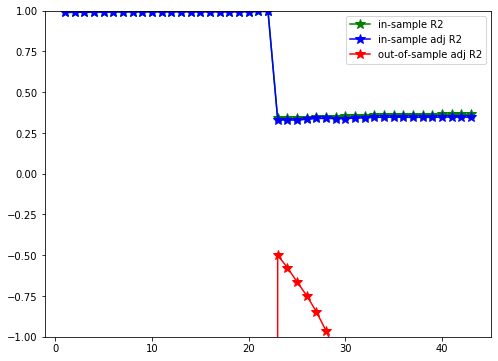

In [74]:
n = len(regressors)
plt.plot(range(1, n), regR2, 'g-*', markersize = 10)
plt.plot(range(1, n), adjR2, 'b-*', markersize = 10)
plt.plot(range(1, n), OSR2, 'r-*', markersize = 10)
plt.ylim((-1,1))
plt.legend(('in-sample R2','in-sample adj R2','out-of-sample adj R2'))

In [75]:
lm, r = AdjR2([1]*i + [0]*(len(regressors)-i))
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     34.86
Date:                Fri, 19 Jun 2020   Prob (F-statistic):          1.35e-117
Time:                        18:53:20   Log-Likelihood:                 2930.2
No. Observations:                1515   AIC:                            -5814.
Df Residuals:                    1492   BIC:                            -5692.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
num_providers      -0.0727      0.008     -9.320      0.000      -0.088      -0.057
k0_k10             -0.0011      0.002     -0.652      0.515      -0.004       0.002
k10_k15             0.0003      0.002      0.164      0.870      -0.003       0.003
k15_k25            -0.0012      0.002     -0.636      0.525      -0.005       0.003
k25_k35            -0.0004      0.002     -0.192      0.848      -0.004       0.003
k35_k50            -0.0005      0.002     -0.257      0.797      -0.005       0.004
k50_k75            -0.0002      0.002     -0.108      0.914      -0.005       0.004
k75_k100            0.0004      0.002      0.185      0.853      -0.004       0.005
k100_k150           0.0026      0.002      1.155      0.248      -0.002       0.007
k150_k200           0.0029      0.002      1.551      0.121      -0.001       0.007
k200_UP             0.0056      0.002      3.540      0.000       0.003       0.009
White              -0.0037      0.001     -2.742      0.006      -0.006      -0.001
Black              -0.0003      0.001     -0.260      0.795      -0.002       0.002
Native              0.0013      0.002      0.565      0.572      -0.003       0.006
Asian              -0.0032      0.001     -3.082      0.002      -0.005      -0.001
Other               0.0073      0.001      6.318      0.000       0.005       0.010
PacificIslander     0.0009      0.006      0.156      0.876      -0.010       0.012
TwoOrMore           0.0061      0.002      3.996      0.000       0.003       0.009
Bronx               6.2562      0.020    312.739      0.000       6.217       6.295
Brooklyn            6.3095      0.021    295.905      0.000       6.268       6.351
Queens              6.3362      0.020    311.688      0.000       6.296       6.376
Manhattan           6.3122      0.024    268.299      0.000       6.266       6.358
Staten_Island       6.3891      0.020    318.041      0.000       6.350       6.429
==============================================================================
Omnibus:                      143.123   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              590.634
Skew:                          -0.368   Prob(JB):                    5.56e-129
Kurtosis:                       5.969   Cond. No.                         460.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

According to the feature selecting, the number of providers, income, race and borough have relatively higher impact on the pricing of broadband.

In [76]:
# predict the pricing
selected_regressors = ['num_providers','k200_UP','White','Black','Native','Asian','Other','TwoOrMore','Bronx','Brooklyn','Queens','Manhattan','Staten_Island','No_Internet']
lm_D = sm.OLS(pqirbas['price'], pqirbas[selected_regressors]).fit()
lm_D.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     81.57
Date:                Fri, 19 Jun 2020   Prob (F-statistic):          2.37e-176
Time:                        18:53:20   Log-Likelihood:                 4166.0
No. Observations:                2165   AIC:                            -8304.
Df Residuals:                    2151   BIC:                            -8225.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
num_providers    -0.0662      0.006    -10.195      0.000      -0.079      -0.053
k200_UP           0.0088      0.001      7.958      0.000       0.007       0.011
White            -0.0025      0.001     -2.306      0.021      -0.005      -0.000
Black             0.0009      0.001      1.103      0.270      -0.001       0.002
Native            0.0022      0.002      1.161      0.246      -0.002       0.006
Asian            -0.0022      0.001     -2.641      0.008      -0.004      -0.001
Other             0.0061      0.001      6.511      0.000       0.004       0.008
TwoOrMore         0.0059      0.001      4.561      0.000       0.003       0.009
Bronx             6.2182      0.016    382.260      0.000       6.186       6.250
Brooklyn          6.2687      0.017    361.658      0.000       6.235       6.303
Queens            6.3026      0.016    384.915      0.000       6.271       6.335
Manhattan         6.2715      0.019    324.641      0.000       6.234       6.309
Staten_Island     6.3473      0.016    390.961      0.000       6.315       6.379
No_Internet       0.0032      0.001      2.439      0.015       0.001       0.006
==============================================================================
Omnibus:                      686.437   Durbin-Watson:                   1.507
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11048.329
Skew:                          -1.055   Prob(JB):                         0.00
Kurtosis:                      13.864   Cond. No.                         325.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
lm_S = sm.OLS(pqirbas['price'], pqirbas['num_providers']).fit()
lm_S.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                          1.984e+05
Date:                Fri, 19 Jun 2020   Prob (F-statistic):                        0.00
Time:                        18:53:20   Log-Likelihood:                         -1311.0
No. Observations:                2165   AIC:                                      2624.
Df Residuals:                    2164   BIC:                                      2630.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
num_providers     2.3980      0.005    445.442      0.000       2.387       2.409
==============================================================================
Omnibus:                      255.501   Durbin-Watson:                   0.634
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              359.856
Skew:                          -0.900   Prob(JB):                     7.22e-79
Kurtosis:                       3.865   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
pqirbas['Demand'] = lm_D.predict()
pqirbas['Supply'] = lm_S.predict()
pqirbas.head()

,num_providers,price,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,k75_k100,k100_k150,...,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP,Demand,Supply
0,1.386294,3.995015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.264877,1.755810,0.868856,0.542521,0.000000,0.000000,0.000000,0.000000,4.232096,3.324361
1,1.609438,4.244882,2.066863,1.223775,2.587764,2.388763,2.525729,3.063391,2.351375,2.797281,...,2.335545,1.499320,1.855376,2.109426,2.258059,1.128685,0.493772,1.217227,4.247805,3.859464
2,1.609438,4.244882,2.104134,1.064711,2.151762,1.504077,2.251292,2.944439,2.901422,2.906901,...,2.109212,2.306023,1.852864,1.690021,1.553369,0.919764,0.868969,0.940767,4.246520,3.859464
3,1.609438,4.244882,2.240710,2.602690,2.549445,2.862201,2.778819,2.933857,2.208274,2.163323,...,2.059836,2.020285,1.763622,1.554982,1.507471,1.725232,1.388363,1.044561,4.238520,3.859464
4,1.609438,4.244882,2.687847,2.424803,2.041220,2.104134,2.954910,3.010621,2.595255,2.459589,...,1.925555,2.011401,1.340506,0.879829,0.254123,0.409676,0.433402,0.000000,4.245308,3.859464


In [79]:
Curve = pqirbas[['num_providers','Demand','Supply']]
Estimated_Demand = []
for i in range(len(Curve)):
    n_provider = Curve.loc[i,'num_providers']
    demand = Curve[Curve['num_providers']==n_provider]['Demand'].mean()
    Estimated_Demand.append(demand)
Curve['Estimated_Demand'] = np.array(Estimated_Demand)
Curve = Curve.sort_values(by='num_providers')
Curve.head()

/Users/yanziyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,num_providers,Demand,Supply,Estimated_Demand
2164,0.693147,4.353742,1.662180,4.353742
1953,1.098612,4.295938,2.634494,4.284172
897,1.098612,4.272407,2.634494,4.284172
2000,1.386294,4.276900,3.324361,4.261381
1890,1.386294,4.276900,3.324361,4.261381


<Figure size 576x432 with 0 Axes>

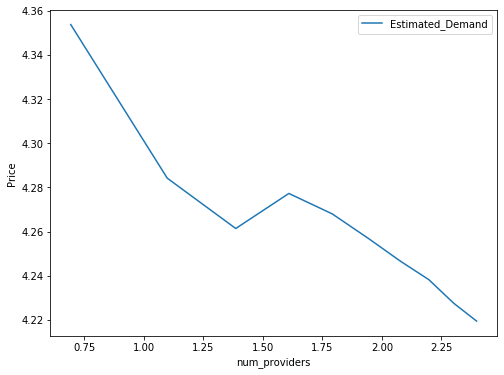

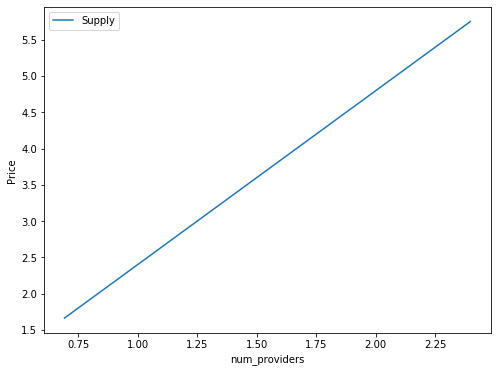

In [80]:
plt.figure()
Curve.plot(x='num_providers',y='Estimated_Demand')
plt.ylabel('Price')
Curve.plot(x='num_providers',y='Supply')
plt.ylabel('Price')
plt.legend(loc='best')

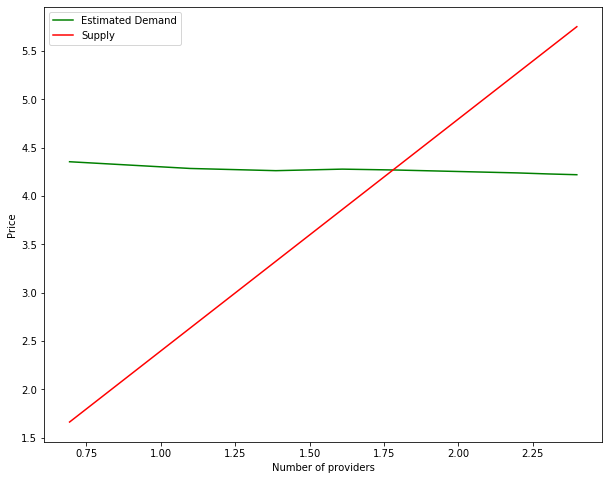

In [51]:
plt.figure(figsize=[10,8])
plt.plot(Curve['num_providers'],Curve['Estimated_Demand'],color='green', label='Estimated Demand')
plt.plot(Curve['num_providers'],Curve['Supply'],color='red', label='Supply')
plt.ylabel('Price')
plt.xlabel('Number of providers')
plt.legend(loc='best')

The price of broadband has relatively less sensitivity to demand than supply. Given the current situation, the regression result indicates the optimal number of providers are near 2, which means it would be better for both customers to have choice and providers to gain more market share. the price ranges from exp(4.25)-1 to exp(4.5)-1, which is approximately [69.1, 89] per line per month.

In [61]:
# For comparison, we redid the regression in 2017 datasets.
# merge data and get log value
pqi = broadband_ISP_merged_concise_2017.merge(income, on='BoroCTLbl')
pqir = pqi.merge(race, on='BoroCTLbl')
pqirb = pqir.merge(borough, on='BoroCTLbl')
pqirba = pqirb.merge(subscription_2017, on='BoroCTLbl')
pqirbas_2017 = pqirba.merge(age, on='BoroCTLbl')
pqirbas_2017 = pqirbas_2017.drop(columns=['BoroCTLbl','county','tract']).fillna(0)
for i in pqirbas_2017.columns:
    pqirbas_2017[i] = pqirbas_2017[i].apply(np.log1p)
pqirbas_2017.head()

,num_providers,price,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,k75_k100,k100_k150,...,A40_A44,A45_A49,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP
0,1.386294,3.995015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.394036,2.238122,2.264877,1.755810,0.868856,0.542521,0.000000,0.000000,0.000000,0.000000
1,1.609438,4.244882,2.066863,1.223775,2.587764,2.388763,2.525729,3.063391,2.351375,2.797281,...,1.972232,2.206090,2.335545,1.499320,1.855376,2.109426,2.258059,1.128685,0.493772,1.217227
2,1.609438,4.244882,2.104134,1.064711,2.151762,1.504077,2.251292,2.944439,2.901422,2.906901,...,2.065185,2.344199,2.109212,2.306023,1.852864,1.690021,1.553369,0.919764,0.868969,0.940767
3,1.609438,4.244882,2.240710,2.602690,2.549445,2.862201,2.778819,2.933857,2.208274,2.163323,...,2.033644,1.957862,2.059836,2.020285,1.763622,1.554982,1.507471,1.725232,1.388363,1.044561
4,1.609438,4.244882,2.687847,2.424803,2.041220,2.104134,2.954910,3.010621,2.595255,2.459589,...,2.067847,1.860190,1.925555,2.011401,1.340506,0.879829,0.254123,0.409676,0.433402,0.000000


In [62]:
# predict the pricing
selected_regressors = ['num_providers','k200_UP','White','Black','Native','Asian','Other','TwoOrMore','Bronx','Brooklyn','Queens','Manhattan','Staten_Island','No_Internet']
lm_D_2017 = sm.OLS(pqirbas_2017['price'], pqirbas_2017[selected_regressors]).fit()
lm_D_2017.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     82.23
Date:                Fri, 19 Jun 2020   Prob (F-statistic):          1.40e-177
Time:                        18:52:45   Log-Likelihood:                 4168.9
No. Observations:                2165   AIC:                            -8310.
Df Residuals:                    2151   BIC:                            -8230.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
num_providers    -0.0694      0.007    -10.544      0.000      -0.082      -0.056
k200_UP           0.0087      0.001      7.894      0.000       0.007       0.011
White            -0.0025      0.001     -2.336      0.020      -0.005      -0.000
Black             0.0009      0.001      1.143      0.253      -0.001       0.002
Native            0.0021      0.002      1.107      0.268      -0.002       0.006
Asian            -0.0021      0.001     -2.565      0.010      -0.004      -0.001
Other             0.0061      0.001      6.504      0.000       0.004       0.008
TwoOrMore         0.0056      0.001      4.293      0.000       0.003       0.008
Bronx             6.2264      0.017    376.614      0.000       6.194       6.259
Brooklyn          6.2755      0.017    359.448      0.000       6.241       6.310
Queens            6.3109      0.017    378.950      0.000       6.278       6.344
Manhattan         6.2631      0.018    347.137      0.000       6.228       6.298
Staten_Island     6.3555      0.017    384.861      0.000       6.323       6.388
No_Internet       0.0031      0.001      2.326      0.020       0.000       0.006
==============================================================================
Omnibus:                      728.007   Durbin-Watson:                   1.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11883.597
Skew:                          -1.141   Prob(JB):                         0.00
Kurtosis:                      14.249   Cond. No.                         325.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
lm_S_2017 = sm.OLS(pqirbas_2017['price'], pqirbas_2017['num_providers']).fit()
lm_S_2017.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          2.898e+05
Date:                Fri, 19 Jun 2020   Prob (F-statistic):                        0.00
Time:                        18:52:50   Log-Likelihood:                         -904.75
No. Observations:                2165   AIC:                                      1812.
Df Residuals:                    2164   BIC:                                      1817.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
num_providers     2.4526      0.005    538.293      0.000       2.444       2.462
==============================================================================
Omnibus:                       81.574   Durbin-Watson:                   1.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.430
Skew:                          -0.478   Prob(JB):                     2.31e-20
Kurtosis:                       3.299   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
pqirbas_2017['Demand_2017'] = lm_D_2017.predict()
pqirbas_2017['Supply_2017'] = lm_S_2017.predict()
Curve_2017 = pqirbas_2017[['num_providers','Demand_2017','Supply_2017']]
Estimated_Demand = []
for i in range(len(Curve_2017)):
    n_provider = Curve_2017.loc[i,'num_providers']
    demand = Curve_2017[Curve_2017['num_providers']==n_provider]['Demand_2017'].mean()
    Estimated_Demand.append(demand)
Curve_2017['Estimated_Demand_2017'] = np.array(Estimated_Demand)
Curve_2017 = Curve_2017.sort_values(by='num_providers')
Curve_2017.head()

/Users/yanziyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,num_providers,Demand_2017,Supply_2017,Estimated_Demand_2017
2164,0.693147,4.357246,1.699996,4.357246
1953,1.098612,4.298197,2.694430,4.278964
1099,1.098612,4.265046,2.694430,4.278964
897,1.098612,4.273649,2.694430,4.278964
2000,1.386294,4.278243,3.399992,4.258401


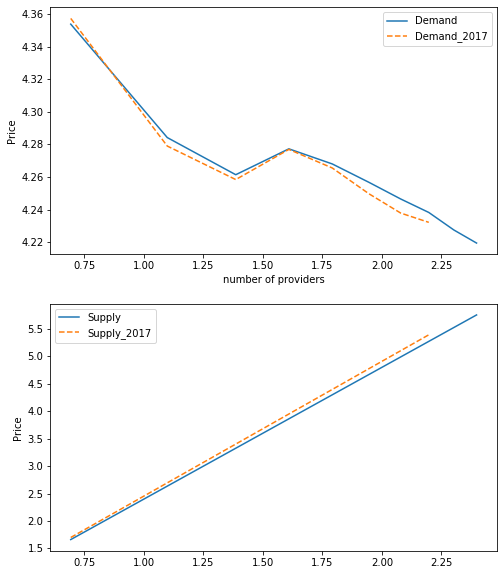

In [94]:
plt.figure(figsize=[8,10])
ax1 = plt.subplot(2, 1, 1)
plt.xlabel('number of providers')
plt.plot(Curve['num_providers'],Curve['Estimated_Demand'],'-',label='Demand')
plt.plot(Curve_2017['num_providers'],Curve_2017['Estimated_Demand_2017'],'--',label='Demand_2017')
plt.ylabel('Price')
plt.legend()
ax2 = plt.subplot(2, 1, 2)
plt.plot(Curve['num_providers'],Curve['Supply'],'-',label='Supply')
plt.plot(Curve_2017['num_providers'],Curve_2017['Supply_2017'],'--',label='Supply_2017')
plt.ylabel('Price')
plt.legend()

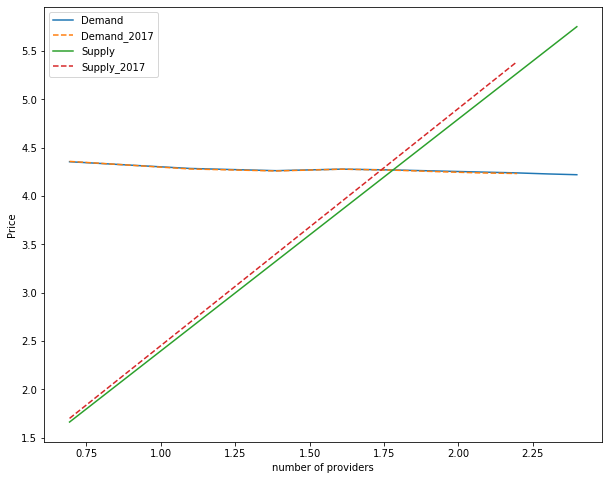

In [97]:
plt.figure(figsize=[10,8])
plt.xlabel('number of providers')
plt.plot(Curve['num_providers'],Curve['Estimated_Demand'],'-',label='Demand')
plt.plot(Curve_2017['num_providers'],Curve_2017['Estimated_Demand_2017'],'--',label='Demand_2017')
plt.ylabel('Price')
plt.plot(Curve['num_providers'],Curve['Supply'],'-',label='Supply')
plt.plot(Curve_2017['num_providers'],Curve_2017['Supply_2017'],'--',label='Supply_2017')
plt.legend()

Compared with the demand curve in 2017, the latest demand curve moves slightly upward, which may result from potential budget increase in the broadband service. People are willing to pay more for the internet access. Besides, the supply curve moves downward, which indicates new tech such as 5G may drag down the cost so the price and competition between companies increases.